In [1]:
import scanpy as sc
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']

In [2]:
adata=sc.read("raw_counts.csv.gz")
adata.var_names_make_unique()
adata.X=csr_matrix(adata.X)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
adata.var["ERCC"]=adata.var_names.str.startswith("ERCC")

In [12]:
adata.var["ERCC"].sum()

92

In [13]:
sc.pp.calculate_qc_metrics(adata,qc_vars=["ERCC"],log1p=False,percent_top=None,inplace=True)

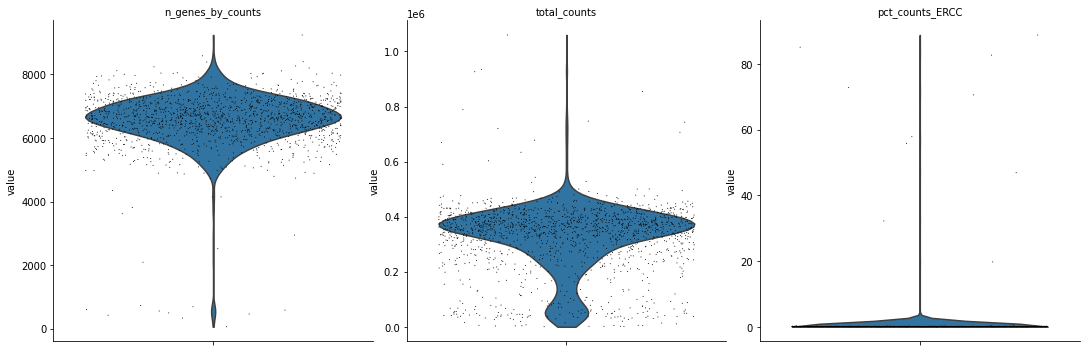

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_ERCC'],
             jitter=0.4, multi_panel=True)

In [15]:
adata = adata[adata.obs.n_genes_by_counts < 8000, :]
adata = adata[adata.obs.n_genes_by_counts > 4000, :]
adata = adata[adata.obs.total_counts > 1e5, :]
adata = adata[adata.obs.total_counts < 5e5, :]
adata = adata[adata.obs.pct_counts_ERCC < 15, :]

In [16]:
adata=adata[:,~adata.var.ERCC]

In [17]:
adata_raw=adata.copy()

In [18]:
import scrublet as scr
scrub = scr.Scrublet(adata.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.5%
Estimated detectable doublet fraction = 55.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.9%
Elapsed time: 3.0 seconds


In [19]:
import scFates as scf

In [20]:
sc.pp.filter_genes(adata,min_cells=3)

Trying to set attribute `.var` of view, copying.


In [21]:
sc.pp.normalize_total(adata,target_sum=1e3)

In [22]:
sc.pp.log1p(adata)

Finding overdispersed features
    computing mean and variances
    gam fitting
    found 3970 over-dispersed features (0:00:01) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



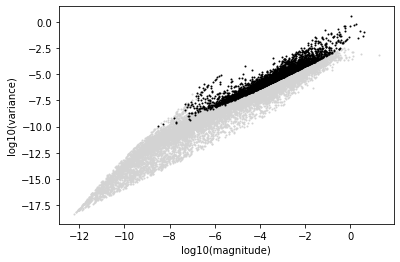

In [23]:
scf.pp.find_overdispersed(adata,plot=True)

In [24]:
adata.layers["scaled"]=sc.pp.scale(adata.X,max_value=10,copy=True)

In [25]:
adata.obsm["X_pca"]=sc.pp.pca(adata[:,adata.var.highly_variable].layers["scaled"])

In [26]:
sc.pp.neighbors(adata,n_neighbors=15,n_pcs=30,metric="cosine")

In [27]:
sc.tl.umap(adata)
sc.tl.leiden(adata)

In [28]:
adata.obs["sample"]=[n.split(":")[0] for n in adata.obs_names]

In [29]:
adata.obs["location"]="Ad"
adata.obs.loc[(adata.obs["sample"]=="SS2_20_123" )|(adata.obs["sample"]=="SS2_20_127"),"location"]="ZO"

In [30]:
adata.obs["treatment"]="PBS (control)"
adata.obs.loc[(adata.obs["sample"]=="SS2_20_121" )|(adata.obs["sample"]=="SS2_20_123"),"treatment"]="5htp"

... storing 'sample' as categorical
... storing 'location' as categorical
... storing 'treatment' as categorical
... storing 'doublets' as categorical


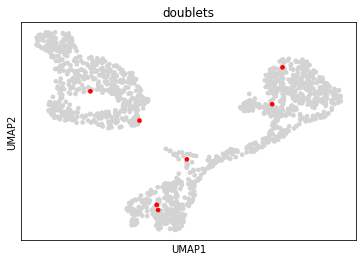

In [31]:
adata.obs["doublets"]=predicted_doublets.astype(str)
sc.pl.umap(adata,color=["doublets"],groups="True",palette=["grey","red"],legend_loc="none")

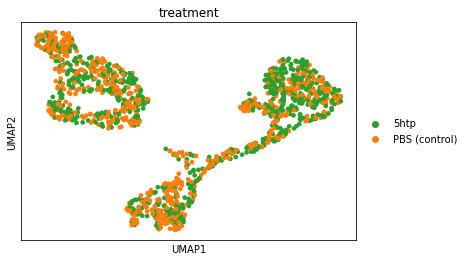

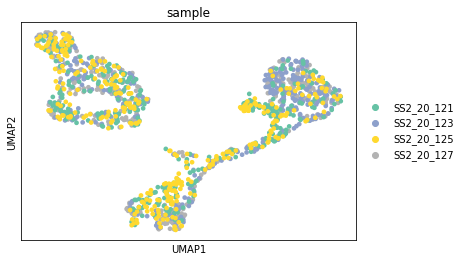

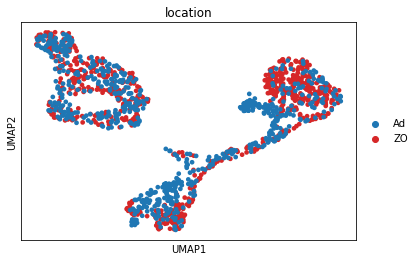

In [32]:
sc.pl.umap(adata,color=["treatment"],palette=["tab:green","tab:orange"])
sc.pl.umap(adata,color=["sample"],palette="Set2")
sc.pl.umap(adata,color=["location"],palette=["tab:blue","tab:red"])

In [38]:
import scvelo as scv

In [39]:
scv.tl.score_genes_cell_cycle(adata,)

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


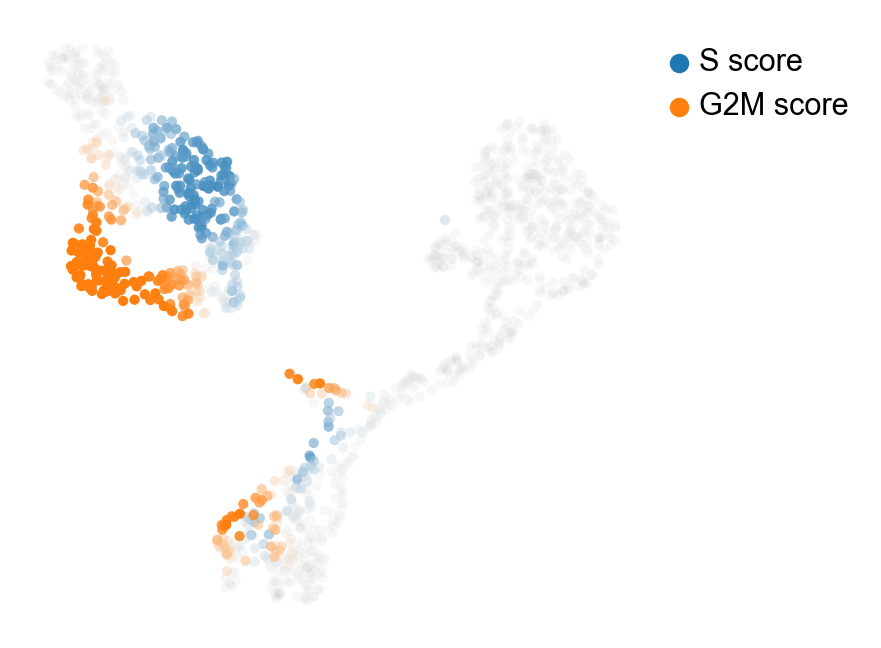

In [40]:
scv.set_figure_params(figsize=(4,4))
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[10, 90])

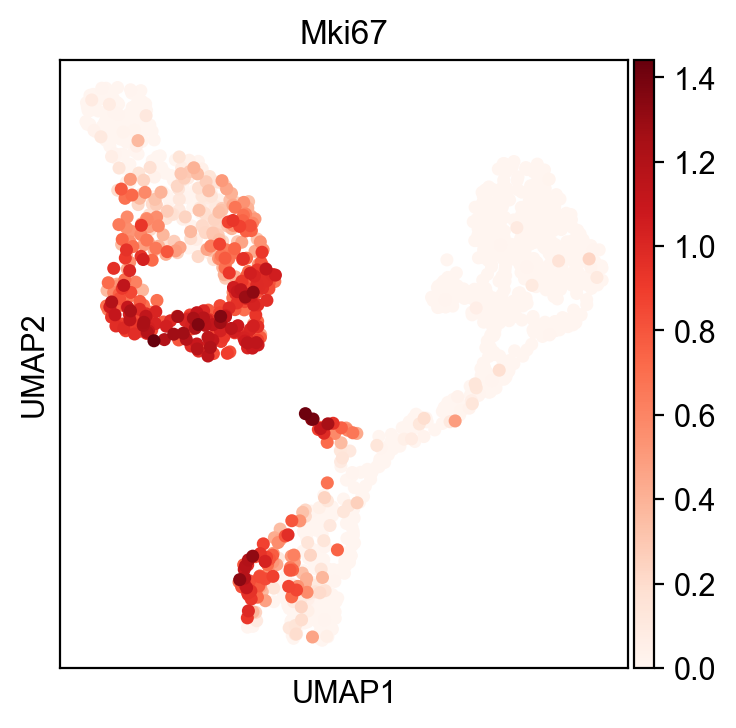

In [41]:
sc.pl.umap(adata,color="Mki67",color_map="Reds")

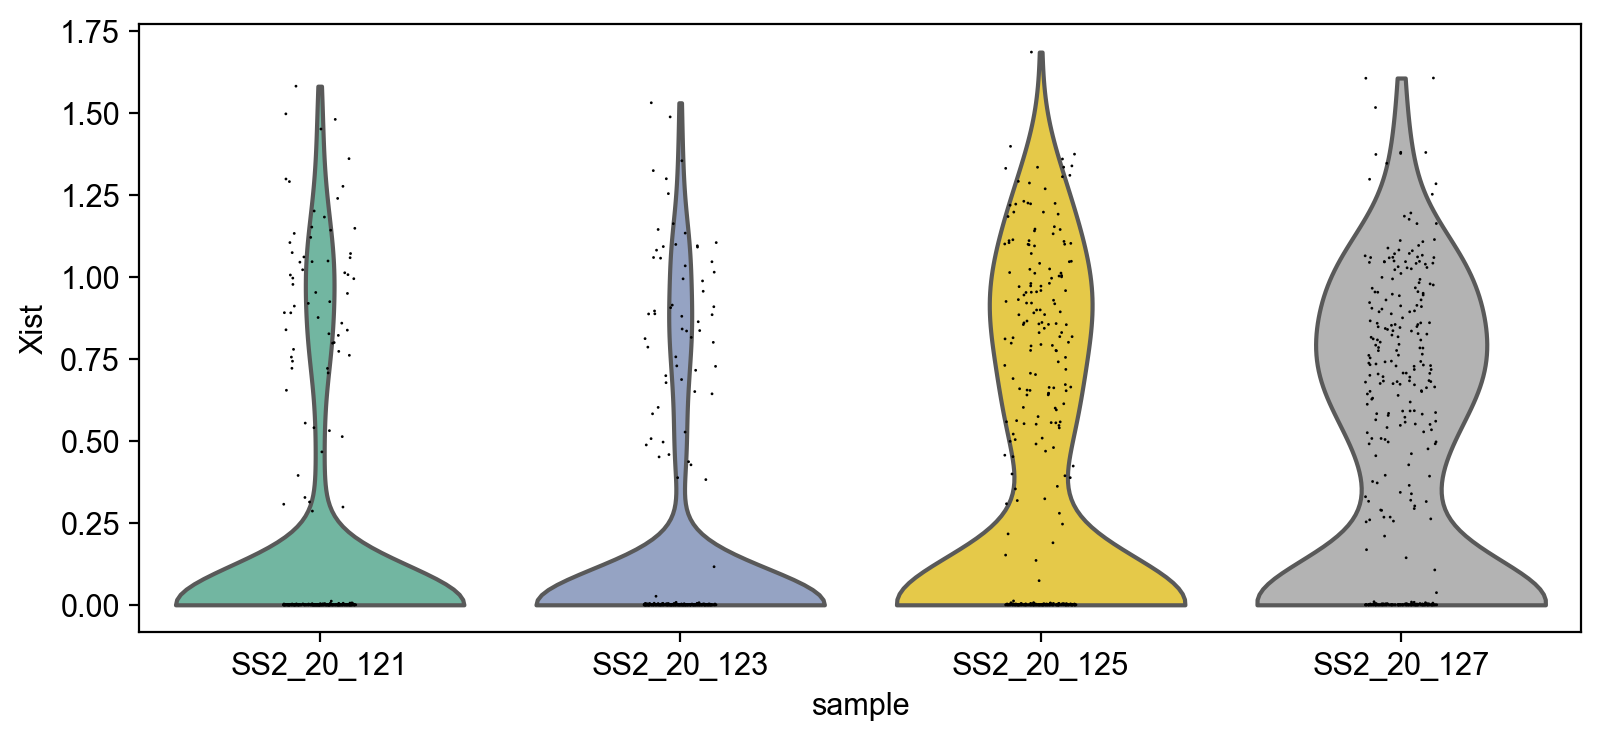

In [42]:
import scvelo as scv
scv.set_figure_params(figsize=(8,4))
sc.pl.violin(adata,"Xist",groupby="sample")

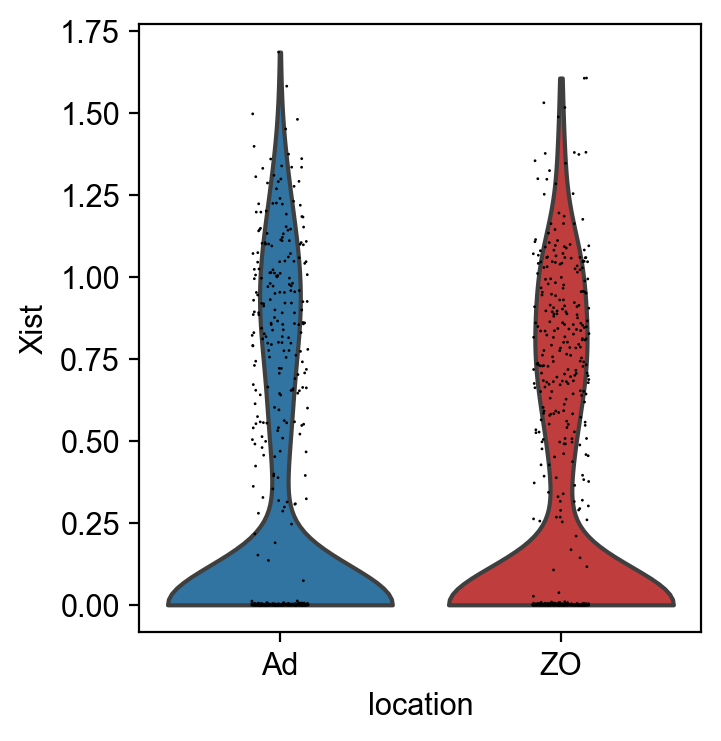

In [43]:
scv.set_figure_params(figsize=(4,4))
sc.pl.violin(adata,"Xist",groupby="location")

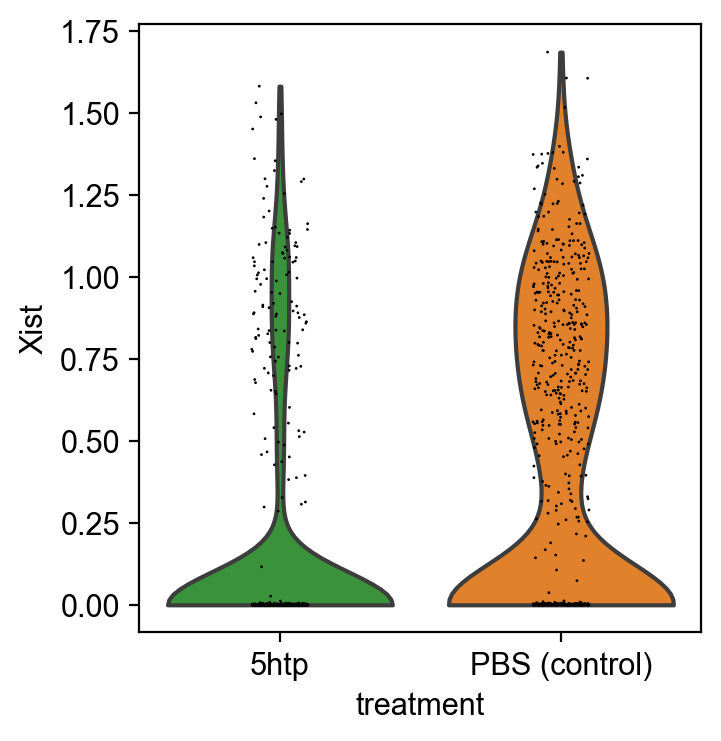

In [44]:
sc.pl.violin(adata,"Xist",groupby="treatment")

In [45]:
s_genes_list = \
    ['Mcm5', 'Pcna', 'Tyms', 'Fen1', 'Mcm2', 'Mcm4', 'Rrm1', 'Ung', 'Gins2',
     'Mcm6', 'Cdca7', 'Dtl', 'Prim1', 'Uhrf1', 'Mlf1ip', 'Hells', 'Rfc2',
     'Rpa2', 'Nasp', 'Rad51ap1', 'Gmnn', 'Wdr76', 'Slbp', 'Ccne2', 'Ubr7',
     'Pold3', 'Msh2', 'Atad2', 'Rad51', 'Rrm2', 'Cdc45', 'Cdc6', 'Exo1', 'Tipin',
     'Dscc1', 'Blm', 'Casp8ap2', 'Usp1', 'Clspn', 'Pola1', 'Chaf1b', 'Brip1', 'E2f8']

g2m_genes_list = \
    ['Hmgb2', 'Cdk1', 'Nusap1', 'Ube2c', 'Birc5', 'Tpx2', 'Top2a', 'Ndc80',
     'Cks2', 'Nuf2', 'Cks1b', 'Mki67', 'Tmpo', 'Cenpf', 'Tacc3', 'Fam64a',
     'Smc4', 'Ccnb2', 'Ckap2l', 'Ckap2', 'Aurkb', 'Bub1', 'Kif11', 'Anp32e',
     'Tubb4b', 'Gtse1', 'Kif20b', 'Hjurp', 'Cdca3', 'Hn1', 'Cdc20', 'Ttk',
     'Cdc25c', 'Kif2c', 'Rangap1', 'Ncapd2', 'Dlgap5', 'Cdca2', 'Cdca8',
     'Ect2', 'Kif23', 'Hmmr', 'Aurka', 'Psrc1', 'Anln', 'Lbr', 'Ckap5',
     'Cenpe', 'Ctcf', 'Nek2', 'G2e3', 'Gas2l3', 'Cbx5', 'Cenpa']

In [46]:
s_genes_list=adata.var_names[adata.var_names.isin(s_genes_list)]
g2m_genes_list=adata.var_names[adata.var_names.isin(g2m_genes_list)]

In [47]:
adata.var.loc[s_genes_list,"highly_variable"]=False
adata.var.loc[g2m_genes_list,"highly_variable"]=False

In [48]:
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=30,n_pcs=30,metric="cosine")

In [53]:
sc.tl.umap(adata)


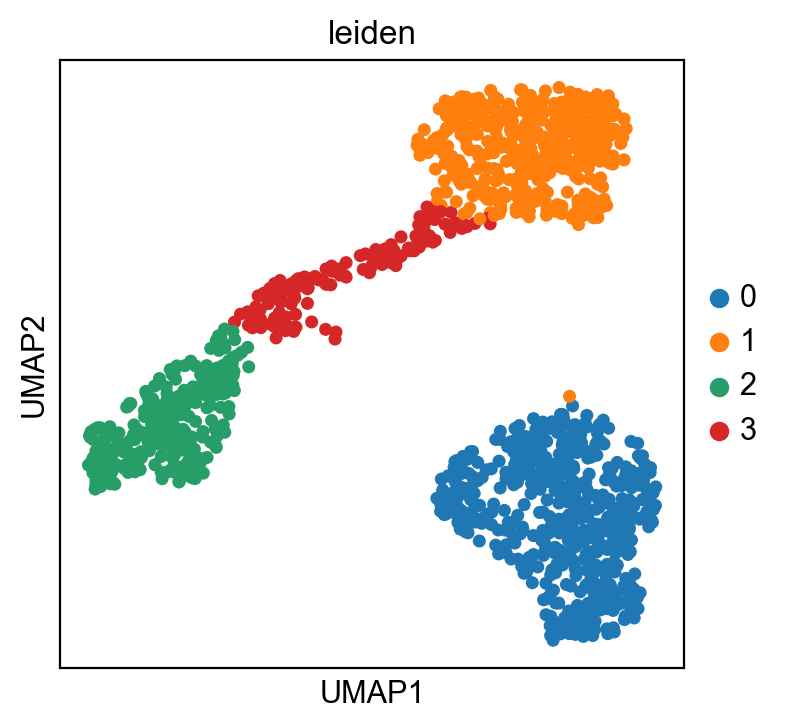

In [55]:
sc.tl.leiden(adata,resolution=.3)
sc.pl.umap(adata,color="leiden")

In [58]:
adata.obs["annot"]=adata.obs.leiden.cat.rename_categories(["Symp","ChC","SCP","bridge"])

In [62]:
adata.write("adata_cc.h5ad")